# BERT Intuitively and Exhaustively Explained

This is a notebook to build and train BERT which follows the tutorial [Link](https://towardsdatascience.com/bert-intuitively-and-exhaustively-explained-48a24ecc1c8a/)

## Load the dataset
load dataset in streaming mode as it is big dataset. 

In [1]:
from datasets import load_dataset
dataset = load_dataset('wikimedia/wikipedia', '20231101.en', trust_remote_code=True, streaming=True)

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

## Data Engineering

In [2]:
import nltk
# nltk.download('punkt') # Sentence tokenizer

### Breaking wikipedia articles into sentences and paragraph

In [3]:
'''
Breaking wikipedia articles into sentences and paragraph
'''
import itertools

num_articles = 1000
dataset_iter = iter(dataset['train'])
# get n articles
articles = list(itertools.islice(dataset_iter, num_articles))

#### Get paragraphs

In [ ]:
# Get paragraphs
paragraphs = []
for article in articles:
    # print(article)
    paragraphs.extend(article['text'].splitlines())

paragraphs = [p for p in paragraphs if len(p) > 50]

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Dividing paragraphs into sentences

In [5]:
# dividing paragraphs into sentences
divided_paragraphs = []
for p in paragraphs:
    divided_paragraphs.append(nltk.sent_tokenize(p))

In [6]:
# only using paragraps with three or more sentences
divided_paragraphs = [pls for pls in divided_paragraphs if len(pls) >= 3]
divided_paragraphs[:5]

[['Anarchism is a political philosophy and movement that is skeptical of all justifications for authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy, typically including nation-states, and capitalism.',
  'Anarchism advocates for the replacement of the state with stateless societies and voluntary free associations.',
  'As a historically left-wing movement, this reading of anarchism is placed on the farthest left of the political spectrum, usually described as the libertarian wing of the socialist movement (libertarian socialism).'],
 ['Humans have lived in societies without formal hierarchies long before the establishment of states, realms, or empires.',
  'With the rise of organised hierarchical bodies, scepticism toward authority also rose.',
  'Although traces of anarchist ideas are found all throughout history, modern anarchism emerged from the Enlightenment.',
  "During the latter half of the 19th and the first decades of the 20th 

## Prepare dataset of following sentence pairs, and random sentence

In [7]:
# Prepare dataset of following sentence pairs, and random sentence

import random

positive_pairs = []
negative_pairs = []

num_paragraphs = len(divided_paragraphs)

for i, paragraph in enumerate(divided_paragraphs):
    for j in range(len(paragraph)-1):
        positive_pairs.append((paragraph[j], paragraph[j+1]))
        rand_par = i
        while rand_par == i:
            rand_par = random.randint(0, num_paragraphs-1)
        rand_sent = random.randint(0, len(divided_paragraphs[rand_par])-1)
        negative_pairs.append((paragraph[j], divided_paragraphs[rand_par][rand_sent]))

In [8]:
positive_pairs[:2]

[('Anarchism is a political philosophy and movement that is skeptical of all justifications for authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy, typically including nation-states, and capitalism.',
  'Anarchism advocates for the replacement of the state with stateless societies and voluntary free associations.'),
 ('Anarchism advocates for the replacement of the state with stateless societies and voluntary free associations.',
  'As a historically left-wing movement, this reading of anarchism is placed on the farthest left of the political spectrum, usually described as the libertarian wing of the socialist movement (libertarian socialism).')]

In [9]:
negative_pairs[:2]

[('Anarchism is a political philosophy and movement that is skeptical of all justifications for authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy, typically including nation-states, and capitalism.',
  'Ælfheah was taken prisoner and held captive for seven months.'),
 ('Anarchism advocates for the replacement of the state with stateless societies and voluntary free associations.',
  'There has been a consequential component of Chinese emigration of illegal origin, most notably Fuzhou people from Fujian Province and Wenzhounese from Zhejiang Province in Mainland China, specifically destined to work in Chinese restaurants in New York City, beginning in the 1980s.')]

## Tokenization

In [10]:
# load tokenizer
from transformers.models.bert.tokenization_bert_fast import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('google-bert/bert-base-uncased')

In [11]:
# Trying out tokenizer
sentence = "Here's a weird word: Withoutadoubticus"
print(f"Original Sentence: {sentence}")
demo_tokens = tokenizer([sentence])
print(f"Token IDs: {demo_tokens['input_ids']}")
tokens = tokenizer.convert_ids_to_tokens(demo_tokens['input_ids'][0])
print(f"token values: {tokens}")

Original Sentence: Here's a weird word: Withoutadoubticus
Token IDs: [[101, 2182, 1005, 1055, 1037, 6881, 2773, 1024, 2302, 9365, 12083, 29587, 102]]
token values: ['[CLS]', 'here', "'", 's', 'a', 'weird', 'word', ':', 'without', '##ado', '##ub', '##ticus', '[SEP]']


In [12]:
tokenizer

BertTokenizerFast(name_or_path='google-bert/bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

## Define Training Batches

In [13]:
# Import required libraries
from tqdm import tqdm
import torch
from multiprocessing import Pool, cpu_count

In [14]:
# defining the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# number of examples in the batch
batch_size = 128 #should be divisible by 2
max_input_length = 64 # sequence lenght of model

In [15]:
device

device(type='cpu')

In [16]:
def process_batch(batch_index):
    # bounds of the batch
    start_index = batch_index * batch_size
    end_index = start_index + batch_size
    
    if end_index > len(positive_pairs):
        return None, None, None
    
    # Get the sentence pairs of the batch and their labels
    sentence_pairs = []
    is_positives = []
    
    # Creating positive pairs
    sentence_pairs.extend(positive_pairs[start_index:start_index + int(batch_size/2)])
    is_positives.extend([1] * int(batch_size/2))
    
    sentence_pairs.extend(negative_pairs[start_index:start_index + int(batch_size/2)])
    is_positives.extend([0] * int(batch_size/2))
    
    # Defining the output
    # In output we need:
    # - The tokens for sequence in a batch
    # - Positioning encoding: to know which sentence it belongs
    # - If the examples in batch are positive or negative
    
    batch_sentence_location_tokens = []
    batch_sequence_tokens = []
    
    # Tokenizing pairs
    for sentence_pair in sentence_pairs:
        sentence1 = sentence_pair[0]
        sentence2 = sentence_pair[1]
        
        # Tokenzing both sentences
        tokens = tokenizer([sentence1, sentence2])
        sentence1_tokens = tokens['input_ids'][0]
        sentence2_tokens = tokens['input_ids'][1]
        
        # Trimming the tokens
        if len(sentence1_tokens) + len(sentence2_tokens) > max_input_length:
            sentence1_tokens = [101] + sentence1_tokens[-int(max_input_length / 2) + 1:] # 101-> CLS token
            sentence2_tokens = sentence2_tokens[:int(max_input_length / 2) - 1] + [102] # 102 -> SEP token
            
        # creating sentence tokens
        sentence_tokens = [0] * len(sentence1_tokens) + [1] * len(sentence2_tokens)

        # combining and padding
        pad_num = max_input_length - len(sentence_tokens)
        sequence_tokens = sentence1_tokens + sentence2_tokens + [0] * pad_num
        sentence_location_tokens = sentence_tokens + [1] * pad_num

        # Adding to batch
        batch_sequence_tokens.append(sequence_tokens)
        batch_sentence_location_tokens.append(sentence_location_tokens)
            
    return torch.tensor(batch_sentence_location_tokens), torch.tensor(batch_sequence_tokens), torch.tensor(is_positives)
    

In [17]:
# Determine the number of batches
num_batches = len(positive_pairs) // batch_size

# Use pool of workers equal to the number of CPU cores
with Pool(processes=cpu_count()) as pool:
    results = list(tqdm(pool.imap(process_batch, range(num_batches)), total=num_batches))
    
# Filter out None results from the process_batch function
results = [result for result in results if result[0] is not None]

# Unpack results into batches
sentence_location_batches, sequence_tokens_batches, is_positive_batches = zip(*results)

# Stack tokens into final batches
sentence_location_batches = torch.stack(sentence_location_batches).to(device)
sequence_tokens_batches = torch.stack(sequence_tokens_batches).to(device)
is_positive_batches = torch.stack(is_positive_batches).to(device)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

## Masking

In [18]:
# List vocab for random token masking
vocab = tokenizer.get_vocab()
valid_token_ids = list(vocab.values())

In [19]:
def mask_batch(batch_tokens, clone=True):
    if clone:
        batch_tokens = torch.clone(batch_tokens)
    
    replace_percentage = 0.15
    
    # Special tokens not to be removed
    exclude_tokens = {0, 100, 101, 102, 103}
    
    # Create a mask to identify tokens that are eligible for replacement
    eligible_mask = ~torch.isin(batch_tokens, torch.tensor(list(exclude_tokens)))
    
    # Count the number of eligible tokens
    num_eligible_tokens = eligible_mask.sum().item()
    
    # Calculate the number of tokens to potentially mask
    num_tokens_to_mask = int(num_eligible_tokens * replace_percentage)
    
    # Create a random permutation of eligible token indices
    eligible_indices = eligible_mask.nonzero(as_tuple = True)
    random_indices = torch.randperm(num_eligible_tokens)[:num_tokens_to_mask]
    
    # Probability distribution for replacement
    replacement_probs = torch.tensor([0.8, 0.1, 0.1]) # [mask, original, random]
    replacement_choices = torch.multinomial(replacement_probs, num_tokens_to_mask, replacement = True)
    
    # Vector to store if token was masked (0: not masked, 1: masked)
    masked_indicator = torch.zeros_like(batch_tokens, dtype=torch.int32)
    
    # Apply replacement on sampled choices
    for i, idx in enumerate(random_indices):
        row = eligible_indices[0][idx]
        col = eligible_indices[1][idx]
        
        # replacing with [MASK]
        if replacement_choices[i] == 0:
            batch_tokens[row, col] = 103
            masked_indicator[row, col] = 1
        # replacing with random token
        elif replacement_choices[i] == 1:
            batch_tokens[row, col] = random.choice(valid_token_ids)
            masked_indicator[row, col] = 1
        # not replacing
        elif replacement_choices[i] == 2:
            masked_indicator[row, col] = 1
    return batch_tokens, masked_indicator
        

In [20]:
batch_tokens, masked_indicator = mask_batch(sequence_tokens_batches[0])

In [21]:
batch_tokens

tensor([[  101,  2015,  2005,  ...,     0,     0,     0],
        [  101,  9617, 11140,  ...,  1007,  1012,   102],
        [  101,  4286,  2031,  ...,     0,     0,     0],
        ...,
        [  101,   103, 13193,  ...,     0,     0,     0],
        [  101,  2011,  1996,  ...,     0,     0,     0],
        [  101,   101,  1996,  ...,  2002,  3062,   102]])

In [22]:
masked_indicator

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)

## Embedding

converting these tokens (which are integers) into high dimensional vector (embedding)

In [23]:
import torch.nn as nn
import torch

In [24]:
vocab_size = tokenizer.vocab_size
d_model = 256 # represneting the words with 256 dimension vector
n_segments = 2 # there are 2 segments

In [25]:
class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model) # token embedding
        self.pos_embed = nn.Embedding(max_input_length, d_model) # positional embedding
        self.seg_embed = nn.Embedding(n_segments, d_model) # segment (token type) embedding
        self.norm = nn.LayerNorm(d_model)
    
    def forward(self, x, seg):
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long).to(device)
        pos = pos.unsqueeze(0).expand_as(x) # seq_len -> (batch_size, seq_len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

In [26]:
e = Embedding()
e.to(device)

Embedding(
  (tok_embed): Embedding(30522, 256)
  (pos_embed): Embedding(64, 256)
  (seg_embed): Embedding(2, 256)
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
)

In [27]:
dummy_embedding = e(sequence_tokens_batches[0], sentence_location_batches[0])
print(dummy_embedding.shape)
print(dummy_embedding)

torch.Size([128, 64, 256])
tensor([[[ 3.7084e-01,  6.2293e-01,  4.2563e-01,  ..., -8.1008e-01,
          -1.2871e+00, -3.7748e-01],
         [-1.8087e+00, -3.9436e-01,  1.6049e+00,  ..., -2.4710e-02,
          -3.0526e-01,  1.0582e-02],
         [ 1.0827e+00, -1.1021e+00,  1.2605e+00,  ..., -3.0210e-01,
          -7.2230e-01,  4.3753e-01],
         ...,
         [ 7.5792e-01, -3.0871e-02, -4.0939e-01,  ...,  8.1252e-01,
          -1.3524e+00, -8.2331e-01],
         [ 1.1915e-01,  1.5688e-01,  5.6939e-01,  ...,  1.8274e+00,
          -9.2547e-01, -7.9873e-01],
         [ 2.7542e-02, -7.2319e-01, -9.3103e-02,  ...,  7.8663e-01,
          -4.2692e-01, -1.8711e+00]],

        [[ 3.7084e-01,  6.2293e-01,  4.2563e-01,  ..., -8.1008e-01,
          -1.2871e+00, -3.7748e-01],
         [-8.7655e-01, -4.3041e-02,  1.6590e+00,  ...,  1.2388e-02,
           6.7928e-01, -7.4830e-01],
         [ 1.5005e+00, -1.2057e+00,  3.8033e-01,  ...,  1.8176e-01,
          -8.3607e-01, -7.6114e-01],
         ...

## Multi-Headed Self Attention

### Single attention head

In [28]:
import numpy as np

In [29]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()
    
    def forward(self, Q, K, V):
        # Q, K, V of size (batch x sequence_lenght x dim)
        scores = torch.matmul(Q,K.transpose(-1,-2)) / np.sqrt(Q.shape[1])
        attn = nn.Softmax(dim=1)(scores)
        context = torch.matmul(attn, V)
        return context, attn
        

In [30]:
# sanity check
q = torch.tensor([[[1.1, 1.3], [0.9, 0.8]]]).to(device)
k = torch.tensor([[[0.9, 1], [0.2, 2.1]]]).to(device)
v = torch.tensor([[[1.1, 1.3], [0.9, 0.8]]]).to(device)

sample = ScaledDotProductAttention().to(device)
sample(q, k, v)

(tensor([[[1.2951, 1.3503],
          [0.7049, 0.7497]]]),
 tensor([[[0.6179, 0.6837],
          [0.3821, 0.3163]]]))

### Understanding the shape transformations

In [31]:
# Defining the sample value matrix
# [batch_size x sequence_len x (query_key_dims * n_heads)]
# in this matrix, [0,1,2,3] represents the values for 2 heads across single word
sample_val = torch.tensor([[[0,1,2,3],[4,5,6,7]],[[0,-1,-2,-3],[-4,-5,-6,-7]]])
sample_val

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7]],

        [[ 0, -1, -2, -3],
         [-4, -5, -6, -7]]])

In [32]:
# dividing into two heads
# [batch_size x sequence_len x query_key_dim x n_heads]
sample_val = sample_val.view(2,2,2,2)
sample_val

tensor([[[[ 0,  1],
          [ 2,  3]],

         [[ 4,  5],
          [ 6,  7]]],


        [[[ 0, -1],
          [-2, -3]],

         [[-4, -5],
          [-6, -7]]]])

In [33]:
# moving the head dimention next to the batch dimension
# [batch_size x n_heads x sequence_len x query_key_dim]
sample_val = sample_val.reshape(-1, 2, 2)
sample_val

tensor([[[ 0,  1],
         [ 2,  3]],

        [[ 4,  5],
         [ 6,  7]],

        [[ 0, -1],
         [-2, -3]],

        [[-4, -5],
         [-6, -7]]])

In [34]:
# that would be the input into MHSA, which would give back the same ouptput
# now we want to unpack the MHSA back into the original shape
# [batch_size x sequence_len x (query_key_dim * n_heads)]
# if we do this right, the values should be exactly identical

# Seperating heads
# [batch_size x n_heads x sequence_len x query_key_dim]
sample_val = sample_val.reshape(2, 2, 2, 2)
sample_val

tensor([[[[ 0,  1],
          [ 2,  3]],

         [[ 4,  5],
          [ 6,  7]]],


        [[[ 0, -1],
          [-2, -3]],

         [[-4, -5],
          [-6, -7]]]])

In [35]:
# moving the head dimension to the end
# [batch_size x sequence_len x query_key_dim x n_heads]
sample_val = sample_val.permute(0, 2, 3, 1)
sample_val

tensor([[[[ 0,  4],
          [ 1,  5]],

         [[ 2,  6],
          [ 3,  7]]],


        [[[ 0, -4],
          [-1, -5]],

         [[-2, -6],
          [-3, -7]]]])

In [36]:
# combining the last dim to effectively concatinate the result of the heads
# [batch_size x sequence_len x query_key_dim*n_heads]
sample_val = sample_val.reshape(2, 2, -1)
sample_val

tensor([[[ 0,  4,  1,  5],
         [ 2,  6,  3,  7]],

        [[ 0, -4, -1, -5],
         [-2, -6, -3, -7]]])

In [37]:
import matplotlib.pyplot as plt

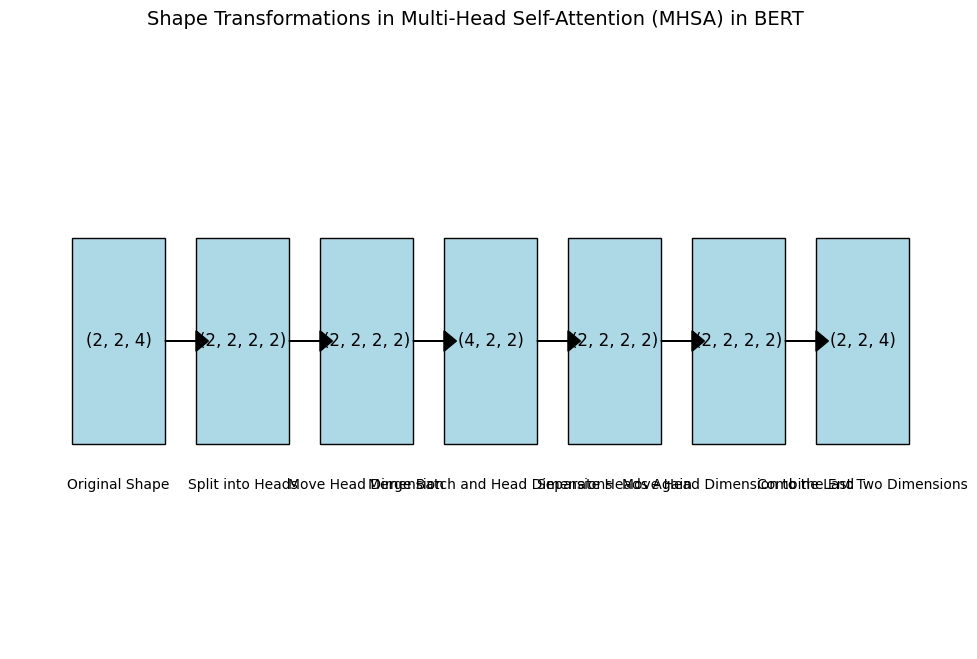

In [38]:
# Define the shapes at each step
shapes = [
    (2, 2, 4),  # Original shape
    (2, 2, 2, 2),  # Split into heads
    (2, 2, 2, 2),  # Move head dimension
    (4, 2, 2),  # Merge batch and head dimensions
    (2, 2, 2, 2),  # Separate heads again
    (2, 2, 2, 2),  # Move head dimension to the end
    (2, 2, 4)  # Combine last two dimensions
]

# Define the labels for each step
labels = [
    "Original Shape",#\n[batch_size, sequence_len, query_key_dim * n_heads]",
    "Split into Heads",#\n[batch_size, sequence_len, query_key_dim, n_heads]",
    "Move Head Dimension",#\n[batch_size, n_heads, sequence_len, query_key_dim]",
    "Merge Batch and Head Dimensions",#\n[batch_size * n_heads, sequence_len, query_key_dim]",
    "Separate Heads Again",#\n[batch_size, n_heads, sequence_len, query_key_dim]",
    "Move Head Dimension to the End",#\n[batch_size, sequence_len, query_key_dim, n_heads]",
    "Combine Last Two Dimensions"#\n[batch_size, sequence_len, query_key_dim * n_heads]"
]

# Create the diagram
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each shape transformation
for i, (shape, label) in enumerate(zip(shapes, labels)):
    rect = plt.Rectangle((i * 2, 0), 1.5, 1, edgecolor='black', facecolor='lightblue')
    ax.add_patch(rect)
    ax.text(i * 2 + 0.75, 0.5, str(shape), ha='center', va='center', fontsize=12)
    ax.text(i * 2 + 0.75, -0.2, label, ha='center', va='center', fontsize=10)

# Draw arrows between shapes
for i in range(len(shapes) - 1):
    ax.arrow(i * 2 + 1.5, 0.5, 0.5, 0, head_width=0.1, head_length=0.2, fc='black', ec='black')

# Set plot limits and remove axes
ax.set_xlim(-1, len(shapes) * 2)
ax.set_ylim(-1, 2)
ax.axis('off')

# Show the plot
plt.title("Shape Transformations in Multi-Head Self-Attention (MHSA) in BERT", fontsize=14)
plt.show()

### Building MHSA

In [39]:
# Define constants
n_heads = 3
query_key_dim = 64
value_dim = 64

In [40]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self):
        super(MultiHeadSelfAttention, self).__init__()
        # Defining the linear layers to construct the query, key, value
        self.W_Q = nn.Linear(d_model, query_key_dim * n_heads) # Projects input to [batch x sequence x (q/k_dim*num_heads)]
        self.W_K = nn.Linear(d_model, query_key_dim * n_heads) # Projects input to [batch x sequence x (q/k_dim*num_heads)]
        self.W_V = nn.Linear(d_model, value_dim * n_heads) # Projects input to [batch x sequence x (value_dim*num_heads)]
        self.dot_prod_attn = ScaledDotProductAttention()   # Parameterless system to calculate attention
        self.proj_back = nn.Linear(value_dim * n_heads, d_model) # Projects final output
        
    def forward(self, embedding):
        # Pass embedding through dense networks
        qs = self.W_Q(embedding) # [batch x sequence x (query_key_dim*num_heads)]
        ks = self.W_K(embedding) # [batch x sequence x (query_key_dim*num_heads)]        
        vs = self.W_V(embedding) # [batch x sequence x (value_dim*num_heads)]
        
        # dividing ot heads
        # [batch_size, sequence_len, q/k/v_dim, n_heads]
        qs = qs.view(batch_size, max_input_length, query_key_dim, n_heads)
        ks = ks.view(batch_size, max_input_length, query_key_dim, n_heads)        
        vs = vs.view(batch_size, max_input_length, value_dim, n_heads)
        
        # moving the head dimension next to the batch dimension
        # [batch_size x n_heads x sequence_len x q/k/v_dim]
        qs = qs.permute(0, 3, 1, 2)
        ks = ks.permute(0, 3, 1, 2)        
        vs = vs.permute(0, 3, 1, 2)
        
        # Combining batch and head dimension
        # [batch_size*n_heads x sequence_len x q/k/v_dim]
        qs = qs.reshape(-1, max_input_length, query_key_dim)
        ks = ks.reshape(-1, max_input_length, query_key_dim)        
        vs = vs.reshape(-1, max_input_length, value_dim)
        
        # Passing batches/heads of self attention through attn
        # [batch_size*n_heads x sequence_len x q/k/v_dim]
        head_results, _ = self.dot_prod_attn(qs, ks, vs)
        
        # Seperating heads
        # [batch_size x n_heads x sequence_len x v_dim]
        head_results = head_results.reshape(batch_size, n_heads, max_input_length, value_dim)
        
        # moving the head dimension to the end
        # [batch_size x sequence_len x query_key_dim x n_heads]
        head_results = head_results.permute(0, 2, 3, 1)
        
        # combinig the last dim to effectively concatinate the result of the heads
        # [batch_size x sequence_len x query_key_dim*n_heads]
        head_results = head_results.reshape(batch_size, max_input_length, -1)
        
        # Projecting result of head back into model dimension
        return self.proj_back(head_results)        

In [41]:
# Example Usage
sample_embeddings = torch.tensor([[[1.1] * d_model] * max_input_length] * batch_size).to(device)
print(f'Sample embeddings shape: {sample_embeddings.shape}')

Sample embeddings shape: torch.Size([128, 64, 256])


In [42]:
sample = MultiHeadSelfAttention().to(device)
output = sample(sample_embeddings)
print(f'Output shape of MHSA: {output.shape}')

Output shape of MHSA: torch.Size([128, 64, 256])


## Pointwise Feed Forward
we’re expanding the vectors to four times their length with a neural network, applying a non-linear activation function, then compressing that data back into the original model dimension length 

In [43]:
d_ff = 4 * d_model

In [44]:
class PointWiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PointWiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x):
        # (batch_size, len_seq, d_model) -> (batch_size, len_seq, d_ff) -> (batch_size, len_seq, d_model)
        return self.fc2(torch.nn.functional.gelu(self.fc1(x)))

## The Encoder Block

In [45]:
class EncoderBlock(nn.Module):
    def __init__(self):
        super(EncoderBlock, self).__init__()
        self.mhsa = MultiHeadSelfAttention()
        self.pwff = PointWiseFeedForwardNet()
        
    def forward(self, x):
        mhsa_output = self.mhsa(x)
        skip1 = mhsa_output + x
        pwff_output = self.pwff(skip1)
        skip2 = skip1 + pwff_output
        return skip2

## Building BERT

In [46]:
n_layers = 1

In [47]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.embedding = Embedding() # convert tokens into vector embeddings
        self.encoder_blocks = nn.ModuleList([EncoderBlock() for _ in range(n_layers)]) # Encoder blocks
        # Decoding a word vector into token predictions
        self.decoder = nn.Linear(d_model, tokenizer.vocab_size, bias=False)
        # Converting first output token into a binary classification
        self.classifier = nn.Linear(d_model, 1, bias = False)
        
    def forward(self, x, seg, masked_token_locations):
        # x of shape [batch x seq_len x model_dim]
        embeddings = self.embedding(x, seg)
        x = embeddings
        for block in self.encoder_blocks:
            x = block(x)
        
        # passing first token through classifier
        clsf_logits = self.classifier(x[:, 0, :])
        
        # passing masked tokens through decoder
        masked_token_embeddings = embeddings[masked_token_locations.bool()]
        token_logits = self.decoder(masked_token_embeddings)
        
        return clsf_logits, token_logits

## Pretraining BERT

In [48]:
import torch.optim as optim
from tqdm import tqdm

In [49]:
model = BERT().to(device)
token_criterion = nn.CrossEntropyLoss() # Expect indices not one-hot vectors
classification_criterion = nn.BCEWithLogitsLoss() # For logits directly
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
losses = [[]]

for epoch in range(4):
    for sequence_batch, location_batch, classtag_batch in tqdm(zip(sequence_tokens_batches, sentence_location_batches, is_positive_batches)):
        # Zeroing out gradients from last iteration
        optimizer.zero_grad()
        
        # Masking the tokens in the input sequence
        masked_tokens, masked_token_locations = mask_batch(sequence_batch)
        
        # Generating class and masked token predictions
        clsf_logits, token_logits = model(masked_tokens, location_batch, masked_token_locations)
        
        # Setting up the target for masked token prediction
        masked_token_targets = sequence_batch[masked_token_locations.bool()]
        
        # Calculating loss for the next sentence classification
        loss_clsf = classification_criterion(clsf_logits.squeeze(), classtag_batch.float())
        
        # Calculating the loss for masked language modeling
        loss_mlm = token_criterion(token_logits, masked_token_targets)
        
        # Combining losses
        loss = loss_clsf + loss_mlm
        
        losses[-1].append(float(loss))
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
    print(f'=====Epoch {epoch} Completed')
    print(f'average loss in epoch: {np.mean(losses[-1])}')
    losses.append([])

744it [09:35,  1.29it/s]


=====Epoch 0 Completed
average loss in epoch: 8.055456192262712


744it [12:14,  1.01it/s]


=====Epoch 1 Completed
average loss in epoch: 7.694260349196773


380it [15:51,  2.65s/it]

## Fine Tuning

In [ ]:
 # Loading dataset
    
fine_tune_ds = load_dataset('fancyzhx/amazon_polarity')

for e in fine_tune_ds['train']:
    print(e)
    break

In [ ]:
# Turning Amazon dataset to BERT friendly dataset

def preprocess_data(data, max_num = 100000):
    data_tokens = []
    data_positional = []
    data_targets = []
    
    # unpacking data
    for i, elem in enumerate(data):
        # Tokenize title and content
        sentence1 = elem['title']
        sentence2 = elem['content']
        tokens = tokenizer([sentence1, sentence2])
        sentence1_tokens = tokens['input_ids'][0]
        sentence2_tokens = tokens['input_ids'][1]
        
        # Trimming down the tokens
        if len(sentence1_tokens) + len(sentence2_tokens) > max_input_length:
            sentence1_tokens = [101] + sentence1_tokens[-int(max_input_length / 2) + 1:]
            sentence2_tokens = sentence2_tokens[:int(max_input_length/2) -1] + [102]

        # Creating Sentence tokens
        sentence_tokens = [0] * len(sentence1_tokens) + [1] * len(sentence2_tokens)
        
        # Combining and padding
        pad_num = max_input_length - (len(sentence1_tokens) + len(sentence2_tokens))
        sequence_tokens = sentence1_tokens + sentence2_tokens + [0] * pad_num
        sentence_location_tokens = sentence_tokens + [1] * pad_num
        
        if not (len(sequence_tokens) == max_input_length and len(sentence_location_tokens) == max_input_length):
            print(len(sequence_tokens), len(sentence_location_tokens))
            print(sentence1_tokens, sentence2_tokens)
        
        # Adding to the batch
        data_tokens.append(sequence_tokens)
        data_positional.append(sentence_location_tokens)
        data_targets.append(elem['label'])

        if i > max_num: break
    
    return torch.tensor(data_positional), torch.tensor(data_tokens), torch.tensor(data_targets)


In [ ]:
# processing data into modeling data
train_pos, train_tok, train_tar = preprocess_data(fine_tune_ds['train'])
test_pos, test_tok, test_tar = preprocess_data(fine_tune_ds['test'])

In [ ]:
# Moving training to device
train_pos = train_pos.to(device)
train_tok = train_tok.to(device)
train_tar = train_tar.to(device)

# Moving testing to device
test_pos = test_pos.to(device)
test_tok = test_tok.to(device)
test_tar = test_tar.to(device)

In [ ]:
# Replacing the classifier head with new head
# Since new problem requires us to classify the review as positive or negative

model.classifier = nn.Linear(d_model, 1, bias=False).to(device)

# Resetting the optimizer to access the parameter of new head
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
ft_losses = [[]*1]

for epoch in range(5):
    for i in tqdm(range(0, train_pos.shape[0], batch_size)):
        
        if i + batch_size >= train_pos.shape[0]:
            break
        
        # Get batch
        train_pos_batch = train_pos[i:i+batch_size]
        train_tok_batch = train_tok[i:i+batch_size]
        train_tar_batch = train_tar[i:i+batch_size]
        
        # Zeroing the gradients from last iteration
        optimizer.zero_grad()
        
        # Masking the tokens in the input sequence
        masked_tokens, masked_token_locations = mask_batch(train_tok_batch)
        
        # Generating class and masked token prediction
        clsf_logits, token_logits = model(train_tok_batch, train_pos_batch, masked_token_locations)
        
        # Setting up target for masked token prediction
        masked_token_targets = sequence_batch[masked_token_locations.bool()]
        
        # Calculating loss for next sentence classification
        loss_clsf = classification_criterion(clsf_logits.squeeze(), train_tar_batch.float())
        
        loss = loss_clsf
        ft_losses[-1].append(float(loss))
        
        loss.backward()
        optimizer.step()
        
    print(f'===== Epoch {epoch} Completed =====')
    print(f'average loss in epoch: {np.mean(ft_losses[-1])}')
    losses.append([])

100%|█████████▉| 781/782 [13:39<00:01,  1.05s/it]


===== Epoch 3 Completed =====
average loss in epoch: 0.691419141126198


100%|█████████▉| 781/782 [13:35<00:01,  1.04s/it]

===== Epoch 4 Completed =====
average loss in epoch: 0.690081260909497


In [59]:
is_correct = []
predicted_class = []
original_class = []

for i in tqdm(range(0, test_pos.shape[0], batch_size)):
    if i+batch_size >= test_pos.shape[0]:
        break
    
    # Getting batch
    test_pos_batch = test_pos[i:i+batch_size]
    test_tok_batch = test_tok[i:i+batch_size]    
    test_tar_batch = test_tar[i:i+batch_size]
    
    # Making prediction
    clsf_logits, _ = model(test_tok_batch, test_pos_batch, torch.zeros(test_pos_batch.shape))
    
    # Converting logits to probability
    res = torch.sigmoid(clsf_logits).round().squeeze()
    
    # Keep track of the original class
    original_class.extend(np.array(test_tar_batch.to('cpu')))
    is_correct.extend(np.array((res == test_tar_batch).to('cpu')))
    predicted_class.extend(np.array(res.detach().to('cpu')))
    
# Accuracy
sum(list(is_correct))/len(is_correct)

100%|█████████▉| 781/782 [01:18<00:00,  9.95it/s]


np.float64(0.515044814340589)